In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spotify-app-reviews-2022/reviews.csv
/kaggle/input/amazon-alexa-reviews/amazon_alexa.tsv


In [2]:
!pip install pyabsa --quiet --root-user-action=ignore
!pip install transformers==4.29.0 --quiet --root-user-action=ignore


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.0 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<2.10,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
tensorflow-serving-api 2.9.0 requires tensorflo

### Importing Required Libraries

In [3]:
from pyabsa import ATEPCCheckpointManager
from pyabsa import available_checkpoints
import re 
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore")

/bin/sh: 1: nvidia-smi: not found


No CUDA GPU found in your device


/opt/conda/lib/python3.7/site-packages/botocore/httpsession.py:41: DeprecationWarning: 'urllib3.contrib.pyopenssl' module is deprecated and will be removed in a future release of urllib3 2.x. Read more in this issue: https://github.com/urllib3/urllib3/issues/2680
  from urllib3.contrib.pyopenssl import orig_util_SSLContext as SSLContext


Version 0.8.7.4 of metric_visualizer is outdated. Version 0.9.9 was released Tuesday July 04, 2023.


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:585: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:637: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.bool,
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/tensor_util.py:108: DeprecationWarning: `np.object` is a deprecated ali

[2023-09-09 14:31:55] (2.0.27) PyABSA(2.0.27): If your code crashes on Colab, please use the GPU runtime. Then run "pip install pyabsa[dev] -U" and restart the kernel.
Or if it does not work, you can use v1.16.27




Try to downgrade transformers<=4.29.0.






In [4]:
data = pd.read_csv("/kaggle/input/spotify-app-reviews-2022/reviews.csv")

In [5]:
data = data.drop(['Time_submitted','Total_thumbsup','Reply'],axis=1)

In [6]:
data.head()

,Review,Rating
0,"Great music service, the audio is high quality...",5
1,Please ignore previous negative rating. This a...,5
2,"This pop-up ""Get the best Spotify experience o...",4
3,Really buggy and terrible to use as of recently,1
4,Dear Spotify why do I get songs that I didn't ...,1


### Reviewing and cleaning of data

In [7]:
data['Rating'].value_counts()

5    22095
1    17653
4     7842
2     7118
3     6886
Name: Rating, dtype: int64

In [8]:
STOPWORDS = stopwords.words("english")

In [9]:
def clean(x):
    x =  x.lower()
    x  =  re.sub("[^\w\d]"," ",x)
    x = " ".join(t for t in x.split() if t not in STOPWORDS)
    return x

In [10]:
data['Review'] = data['Review'].apply(lambda x : clean(x))

In [11]:
data.head()

,Review,Rating
0,great music service audio high quality app eas...,5
1,please ignore previous negative rating app sup...,5
2,pop get best spotify experience android 12 ann...,4
3,really buggy terrible use recently,1
4,dear spotify get songs put playlist shuffle play,1


In [12]:
data['Review'][0:10]

0    great music service audio high quality app eas...
1    please ignore previous negative rating app sup...
2    pop get best spotify experience android 12 ann...
3                   really buggy terrible use recently
4     dear spotify get songs put playlist shuffle play
5    player controls sometimes disappear reason app...
6        love selection lyrics provided song listening
7    still extremely slow changing storage external...
8    great app best mp3 music app ever used one pro...
9    deleting app following reasons app failing bus...
Name: Review, dtype: object

(array([17653.,     0.,  7118.,     0.,     0.,  6886.,     0.,  7842.,
            0., 22095.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

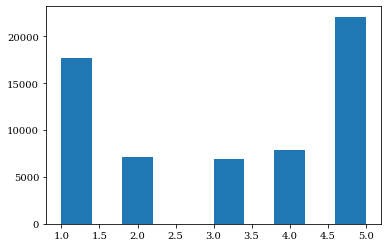

In [13]:
plt.hist(data['Rating'])

In [14]:
text =list(data['Review'].values) # Taking Only 5 sentences

In [15]:
text = list(data['Review'][0:100])

In [16]:
text

['great music service audio high quality app easy use also quick friendly support',
 'please ignore previous negative rating app super great give five stars',
 'pop get best spotify experience android 12 annoying please let get rid',
 'really buggy terrible use recently',
 'dear spotify get songs put playlist shuffle play',
 'player controls sometimes disappear reason app restart forgets playing fixes issue',
 'love selection lyrics provided song listening',
 'still extremely slow changing storage external sd card convinced done purpose spotify knows issue done nothing solve time changed sd cards faster read write speeds samsung brand please add like song never appear searches playlists',
 'great app best mp3 music app ever used one problem play songs find songs despite app wonderful recommend best',
 'deleting app following reasons app failing business model whether streaming services like consumer want pay music fully 6 ads successively upon logging single song much closed app ad num

## Snetiment Analysis Part

In [17]:
checkpoint_map = available_checkpoints()

[2023-09-09 14:32:03] (2.0.27) Please specify the task code, e.g. from pyabsa import TaskCodeOption


In [18]:
aspect_extractor = ATEPCCheckpointManager.get_aspect_extractor(checkpoint='english',
                                   auto_device=True 
                                   )

[2023-09-09 14:32:04] (2.0.27) ********** Available ATEPC model checkpoints for Version:2.0.27 (this version) **********
[2023-09-09 14:32:04] (2.0.27) ********** Available ATEPC model checkpoints for Version:2.0.27 (this version) **********
[2023-09-09 14:32:04] (2.0.27) Downloading checkpoint:english 
[2023-09-09 14:32:04] (2.0.27) Notice: The pretrained model are used for testing, it is recommended to train the model on your own custom datasets


[2023-09-09 14:32:38] (2.0.27) Find zipped checkpoint: ./checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43.zip, unzipping


[2023-09-09 14:32:46] (2.0.27) Done.
[2023-09-09 14:32:46] (2.0.27) If the auto-downloading failed, please download it via browser: https://huggingface.co/spaces/yangheng/PyABSA/resolve/main/checkpoints/English/ATEPC/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43.zip 
[2023-09-09 14:32:46] (2.0.27) Load aspect extractor from ./checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43
[2023-09-09 14:32:46] (2.0.27) config: ./checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43/fast_lcf_atepc.config
[2023-09-09 14:32:46] (2.0.27) state_dict: ./checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43/fast_lcf_atepc.state_dict
[2023-09-09 14:32:46] (2.0.27) model: None
[2023-09-09 14:32:46] (2.0.27) tokenizer: ./checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43/fast_lcf_atepc.tokenizer
[202

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [19]:
atepc_result = aspect_extractor.extract_aspect(inference_source=text,  #
                          pred_sentiment=True,
                          )

extracting aspect terms: 100%|██████████| 4/4 [01:20<00:00, 20.21s/it]


[2023-09-09 14:35:11] (2.0.27) The results of aspect term extraction have been saved in /kaggle/working/Aspect Term Extraction and Polarity Classification.FAST_LCF_ATEPC.result.json
[2023-09-09 14:35:11] (2.0.27) Example 0: great <music:Positive Confidence:0.9989745616912842> service audio high quality app easy use also quick friendly support
[2023-09-09 14:35:11] (2.0.27) Example 1: please ignore previous negative rating app super great give five stars
[2023-09-09 14:35:11] (2.0.27) Example 2: pop get best spotify experience <android:Negative Confidence:0.9992020726203918> 12 annoying please let get rid
[2023-09-09 14:35:11] (2.0.27) Example 3: really buggy terrible <use:Negative Confidence:0.9991825222969055> recently
[2023-09-09 14:35:11] (2.0.27) Example 4: dear spotify get songs put playlist <shuffle:Negative Confidence:0.9967742562294006> play
[2023-09-09 14:35:11] (2.0.27) Example 5: player controls sometimes disappear reason app restart forgets playing fixes issue
[2023-09-09 1

In [20]:
atepc_result[0:5]

[{'sentence': 'great music service audio high quality app easy use also quick friendly support',
  'IOB': ['O', 'B-ASP', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
  'tokens': ['great',
   'music',
   'service',
   'audio',
   'high',
   'quality',
   'app',
   'easy',
   'use',
   'also',
   'quick',
   'friendly',
   'support'],
  'aspect': ['music'],
  'position': [[2]],
  'sentiment': ['Positive'],
  'probs': [[0.0008199472213163972,
    0.00020553685317281634,
    0.9989745616912842]],
  'confidence': [0.9989745616912842]},
 {'sentence': 'please ignore previous negative rating app super great give five stars',
  'IOB': ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
  'tokens': ['please',
   'ignore',
   'previous',
   'negative',
   'rating',
   'app',
   'super',
   'great',
   'give',
   'five',
   'stars'],
  'aspect': [],
  'position': [],
  'sentiment': [],
  'probs': [],
  'confidence': []},
 {'sentence': 'pop get best spotify experience android 12 ann